# <center>ALGORITHMES DE DETECTION DU WHEEL-SPINNING    *(EVIDENCE B)* : FONCTIONS DE PREPROCESSING DES DONNEES ET D'ENTRAINEMENT D'UN MODELE LSTM<center/>

## Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
from tensorflow.keras.metrics import Recall, Precision
from Graphs import requirements_functions as rq
from pickle import dump
from skl2onnx import to_onnx
from onnxruntime import InferenceSession

## Récupération et préparation des données

Fonction de récupération des données :

In [2]:
def fetch_data(dump_url):

    if not os.path.isdir("Datasets"):
        os.makedirs("Datasets")
        df = pd.read_csv(dump_url)
        df.to_csv("Datasets/dump.csv", index=False)
        return df

    else:
        return pd.read_csv("Datasets/dump.csv")

Application de la fonction :

In [3]:
DUMP_ROOT = "https://raw.githubusercontent.com/EvidenceB/wheel-spinning/main/Datasets/dump.csv"
GITHUB_TOKEN = "token=ANA3ZLFD4DLR3I3D454JAO3BH2JGC"
DUMP_URL = DUMP_ROOT + "?" + GITHUB_TOKEN

load_data = fetch_data(DUMP_URL)

Fonction de sélection des données pour une application :

In [4]:
def select_application(fichier_config_json, raw_data = load_data):
    module_liste = []
    for module in rq.modules_ids(fichier_config_json):
        module_liste.append(module)
    cond = raw_data.module_id.isin(module_liste)
    df = raw_data[cond]
    #df preprocessing for timestep and homepage
    df["minute"] = pd.DatetimeIndex(df['ts']).minute
    df["heure"] = pd.DatetimeIndex(df['ts']).hour
    df["jour"] = pd.DatetimeIndex(df['ts']).day
    df["mois"] = pd.DatetimeIndex(df['ts']).month
    df["annee"] = pd.DatetimeIndex(df['ts']).year
    df = df.drop("homepage", axis = 1)
    return df

Application de la fonction : 

In [5]:
json_atticus = rq.json_reader("Graphs/config_atticus.json")
data = select_application(json_atticus, load_data)

Fonction de préparation des données calcul de la maîtrise d'une activité

In [6]:
def mastery_building(df = data , success_rate = 0.9):
    
    df = df.drop(["exercise_id", "module_id", "objective_id"], axis = 1) 
    df = df[["student_id", "activity_id", "ts", "heure", "duration", "score"]] 
    df = df.sort_values(by = ["student_id", "activity_id", "ts"]) 
    interaction_col = df.groupby(["student_id","activity_id"]).cumcount() + 1 
    df["interaction_num"] = interaction_col 
    score_at_inter = df.groupby(["student_id","activity_id"])['score'].rolling(window=4).mean() 
    df["score_at_inter"] = score_at_inter.values 
    df["mastery"] = np.where(df['score_at_inter']>=success_rate, 1, 0)
    df.loc[df['score_at_inter'].isna(), "mastery"] = np.nan 
    return df

Application de la fonction : 

In [7]:
data = mastery_building(data)

Fonction de calcul du wheel-spinning sur une activité :

In [8]:
def ws_manage(df, id_eleve, id_activite):
    
    filer = df[(df["student_id"] == id_eleve) & (df["activity_id"] == id_activite)]
    nombre_interaction = filer.shape[0]
    master = filer["mastery"].sum()
    return id_eleve, id_activite, nombre_interaction, master

def ws_building(df = data , ws_interact_seuil = 20):
    
    df = df.drop(df[df.interaction_num > ws_interact_seuil].index)

    liste_eleve = df["student_id"].unique() 
    indetermination = []

    for eleve in liste_eleve:
        liste_activite = df[df["student_id"] == eleve]["activity_id"].unique()

        for activite in liste_activite:
            infos_eleve = ws_manage(df, eleve, activite)
            if ((infos_eleve[2] < ws_interact_seuil) & (infos_eleve[3] == 0)):
                indetermination.append(infos_eleve[0] + infos_eleve[1])

    df["key"] = df["student_id"] + df["activity_id"]
    df = df.set_index("key")
    df = df.drop(df.loc[indetermination, ].index)
    df = df.reset_index()
    del df["key"]

    df = df.sort_values(by = ['student_id', 'activity_id', 'ts'])
    df["key"] = df["student_id"] + df["activity_id"]
    df["wheel-spinning"] = None

    w = df.groupby(["student_id", "activity_id"]).agg({"mastery" : "sum"}).reset_index()
    w["wheel-spinning"] = np.where(w["mastery"] >= 1, 0, 1)
    w["key"] = w["student_id"] + w["activity_id"]

    for key in w["key"].unique():
        df.loc[df["key"] == key, "wheel-spinning"] = w.loc[w["key"] == key, "wheel-spinning"].values[0]

    del df["key"]
    
    plt.figure(dpi = 120)
    labels = ["Non WS", "WS"]
    w["wheel-spinning"].value_counts("normalize = True").plot(kind = "pie", autopct='%1.1f%%', shadow=True, labels=labels)
    plt.axis('off')
    plt.title("Distribution du wheel-spinning")
    plt.show()
    del w
    
    return df

Application de la fonction : 

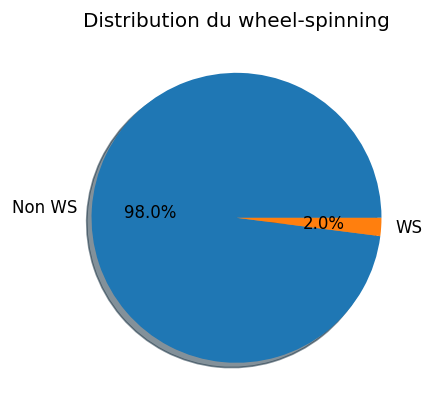

In [9]:
data = ws_building(data)

## Prédiction du wheel-spinning par LSTM

Fonction de prétraitement des données pour le réseaux de neurones

In [10]:
def preprocessing_for_nn(df = data):
    
    #preprocessing for matrix design
    X = df[["heure", "duration", "score"]].values
    liste_eleve = list(df["student_id"].unique())
    X_sequence = []
    for eleve in liste_eleve:
        d = df[(df["student_id"] == eleve)]
        liste_activite = list(d["activity_id"].unique())
        for activite in liste_activite:
            d2 = d[d["activity_id"] == activite]
            une_sequence_X = d2[["heure", "duration", "score"]].values
            une_sequence_Y = d2[["wheel-spinning"]].values
            X_sequence.append(une_sequence_X)
    X_seq = pad_sequences(X_sequence, maxlen=20, dtype="float32", padding="post", value = -10.)

    #normalization of trainning dataset
    X_train_copy = np.copy(X_seq)
    train_reshape = X_train_copy.reshape(-1, X_seq.shape[-1])
    colonnes = ["col" + str(i) for i in range(1, X_seq.shape[2] + 1)]
    train_df = pd.DataFrame(train_reshape, columns = colonnes)
    train_df_no_mask = train_df[train_df["col1"] != -10]
    scaler = StandardScaler()
    train_df_no_mask_norm = scaler.fit_transform(train_df_no_mask.values)
    train_df.iloc[train_df_no_mask.index,] = train_df_no_mask_norm
    X_train = train_df.values.reshape(X_seq.shape)
    
    #if os.path.exists("scaler.pkl"):
    #    os.remove("scaler.pkl")
    #dump(scaler, open('scaler.pkl', 'wb'))    
    
    if os.path.exists("scaler.onnx"):
        os.remove("scaler.onnx")
    onx = to_onnx(scaler, X = train_df_no_mask.to_numpy())
    with open('scaler.onnx', 'wb') as f:
        f.write(onx.SerializeToString())
    
    
    #preprocessing for label
    y = df[["student_id", "activity_id", "wheel-spinning"]].drop_duplicates()["wheel-spinning"].values.astype("float32")
    y_train = y
    
    return X_train, y_train

Application de la fonction :

In [11]:
X_train, y_train = preprocessing_for_nn(data)

Fonction d'entraînement du réseau de neuronnes :

In [12]:
def build_model():
    model = Sequential()
    model.add(Masking(mask_value = -10.))
    model.add(LSTM(64, input_shape = (20, 3), return_sequences = True))
    model.add(LSTM(32, return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=["accuracy", Recall(name = "recall"), Precision(name = "precision")])
    return model

def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def train_lstm(X_train, y_train):
    
    #cross-validation for fine turning
    k = 5
    num_val_samples = len(X_train) // k
    num_epochs = 300
    all_rec_histories = []
    all_prec_histories = []
    all_acc_histories = []

    for i in range(k):
        print(f"Traitement fold #{i} : OK !")
        val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

        partial_X_train = np.concatenate(
            [X_train[:i * num_val_samples],
             X_train[(i + 1) * num_val_samples:]],
            axis=0)

        partial_y_train = np.concatenate(
            [y_train[:i * num_val_samples],
             y_train[(i + 1) * num_val_samples:]],
            axis=0)

        model = build_model()
        weights = {0:1, 1:100}
        history = model.fit(partial_X_train, partial_y_train, epochs = num_epochs, batch_size = 256, class_weight=weights, verbose = 0)

        rec_history = history.history["recall"]
        all_rec_histories.append(rec_history)

        prec_history = history.history["precision"]
        all_prec_histories.append(prec_history)

        acc_history = history.history["accuracy"]
        all_acc_histories.append(acc_history)
        
    average_rec_history = [np.mean([x[i] for x in all_rec_histories]) for i in range(num_epochs)]
    average_prec_history = [np.mean([x[i] for x in all_prec_histories]) for i in range(num_epochs)]
    average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
    
    smoothed_rec_history = smooth_curve(average_rec_history[10:])
    plt.figure(dpi = 80, figsize = (10,5))
    plt.plot(range(1, len(smoothed_rec_history) + 1), smoothed_rec_history)
    plt.ylabel("Validation Recall Smoothed")
    plt.xlabel("Epochs")
    plt.show()
    
    smoothed_prec_history = smooth_curve(average_prec_history[10:])
    plt.figure(dpi = 80, figsize = (10,5))
    plt.plot(range(1, len(smoothed_prec_history) + 1), smoothed_prec_history)
    plt.ylabel("Validation Precision Smoothed")
    plt.xlabel("Epochs")
    plt.show()
    
    smoothed_acc_history = smooth_curve(average_acc_history[10:])
    plt.figure(dpi = 80, figsize = (10,5))
    plt.plot(range(1, len(smoothed_acc_history) + 1), smoothed_acc_history)
    plt.ylabel("Validation Accuracy Smoothed")
    plt.xlabel("Epochs")
    plt.show()
    
    print("Entraînement par Validation Croisée et fine-turning terminé !")
    
    #final trainning
    opti_epoch = np.argmax(smoothed_prec_history)
    model = build_model()
    weights = {0:1, 1:100}
    model.fit(X_train, y_train, epochs = opti_epoch, batch_size = 256, class_weight = weights, verbose=0)
    print("Entrainement, avec fine turning obtenue par VC, sur le jeu de données total terminé !")
    
    if os.path.exists("ws_model.h5"):
        os.remove("ws_model.h5")
    model.save("ws_model.h5")
    print("Modèle enregistré dans le repertoire courant : ws_model.h5 !")

Application de la fonction :

Traitement fold #0 : OK !
Traitement fold #1 : OK !
Traitement fold #2 : OK !
Traitement fold #3 : OK !
Traitement fold #4 : OK !


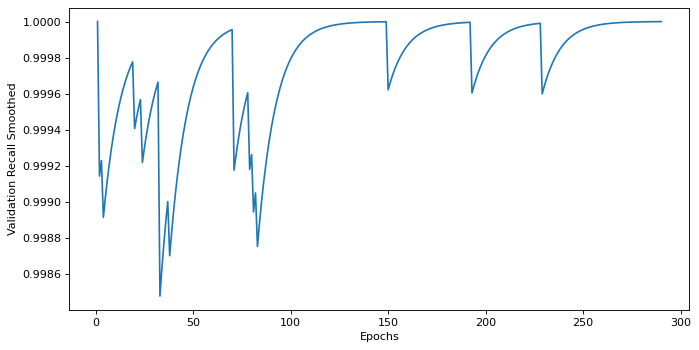

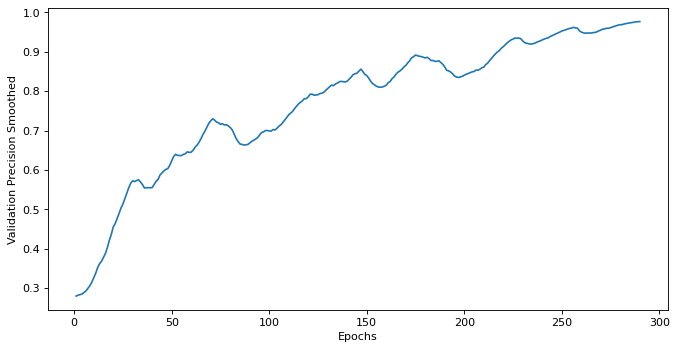

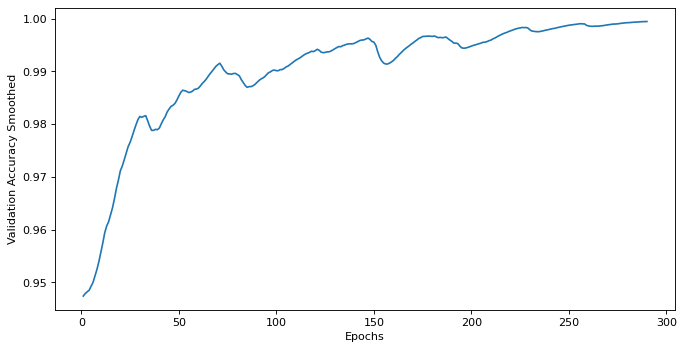

Entraînement par Validation Croisée et fine-turning terminé !
Entrainement, avec fine turning obtenue par VC, sur le jeu de données total terminé !
Modèle enregistré dans le repertoire courant : ws_model.h5 !


In [13]:
train_lstm(X_train, y_train)